# Library import 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
from keras.api.models import Model
from keras.api.layers import Input, Dense, Activation, Flatten, LeakyReLU, BatchNormalization
from keras.api.optimizers import Adam
from keras.api.losses import binary_crossentropy, categorical_crossentropy
from keras.api.utils import to_categorical
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd

# Part 1 : Binary classification

## Preparation of the dataset

In [2]:
# We only need to load and merge 2 datasets for each train_test and val distrib, that's why I don't use a portable function 
 
ernest_celestine_01 = r'C:\Users\Jalil\Desktop\Ecole\M2TSI\tp2\datasets\Movies\ernest_celestine_01'
ernest_celestine_02 = r'C:\Users\Jalil\Desktop\Ecole\M2TSI\tp2\datasets\Movies\ernest_celestine_02'
toy_story_1_01 = r'C:\Users\Jalil\Desktop\Ecole\M2TSI\tp2\datasets\Movies\toy_story_1_01'
toy_story_1_02 = r'C:\Users\Jalil\Desktop\Ecole\M2TSI\tp2\datasets\Movies\toy_story_1_02'

In [3]:
# We create empty np.array to store our images 

dataset_bin_01 = np.empty(shape=(1000, 540, 920, 3), dtype=np.float32) # Train_test dataset
dataset_bin_02 = np.empty(shape=(1000, 540, 920, 3), dtype=np.float32) # Val dataset

In [4]:
# Storage of the images
i = 0
for image_1, image_2 in zip(os.listdir(ernest_celestine_01), os.listdir(ernest_celestine_02)):
    dataset_bin_01[i] = cv2.imread(os.path.join(ernest_celestine_01, image_1)) / 255.0 # We normalize the data 
    dataset_bin_02[i] = cv2.imread(os.path.join(ernest_celestine_02, image_2)) / 255.0
    i += 1

for image_1, image_2 in zip(os.listdir(toy_story_1_01), os.listdir(toy_story_1_02)):
    dataset_bin_01[i] = cv2.imread(os.path.join(toy_story_1_01, image_1)) / 255.0
    dataset_bin_02[i] = cv2.imread(os.path.join(toy_story_1_02, image_2)) / 255.0
    i += 1
    
    

In [5]:
dataset_bin_01npy = r'C:\Users\Jalil\Desktop\Ecole\M2TSI\tp2\datasets\dataset_bin_01.npy'
dataset_bin_02npy = r'C:\Users\Jalil\Desktop\Ecole\M2TSI\tp2\datasets\dataset_bin_02.npy'

In [6]:
# We save our datasets in binary in a npy file to load it faster the next time we want to use it 

with open(dataset_bin_01npy, 'wb') as f:
    np.save(f, dataset_bin_01)
with open(dataset_bin_02npy, 'wb') as f:
    np.save(f, dataset_bin_02)

In [7]:
# We can load the datasets we saved earlier 

with open(dataset_bin_01npy, 'rb') as f:
    dataset_bin_01 = np.load(f)
with open(dataset_bin_02npy, 'rb') as f:
    dataset_bin_02 = np.load(f)

In [8]:
# Now we need to create our target vector

target_bin_01 = np.zeros(dataset_bin_01.shape[0])
target_bin_01[500:] = 1
target_bin_01 = target_bin_01.reshape((-1,1))

target_bin_02 = np.zeros(dataset_bin_01.shape[0])
target_bin_02[500:] = 1
target_bin_02 = target_bin_02.reshape((-1,1))

In [9]:
# We need to create function to exctract features of an image

# Simple features extraction 
def extract_simple_features(image):
    return np.array([np.mean(image[:,:,0]), np.mean(image[:,:,1]), np.mean(image[:,:,2])])

# Complex features extraction 
def extract_features(image):
    
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    epsilon = 1e-10 # to prevent the division by 0
    
    hist, bin = np.histogram(image_gray, bins=10)
    bin = bin[1:]
    
    fft_image = np.log(np.abs(np.fft.fftshift(np.fft.fft2(image_gray))) + epsilon)
    hist1, bin1 = np.histogram(fft_image, bins=10)
    bin1 = bin1[1:]

    return np.concatenate([
        np.array([np.mean(image), np.mean(image[:,:,0]), np.mean(image[:,:,1]), np.mean(image[:,:,2])]),
        (hist*bin/np.sum(hist)),
        (hist1*bin1)/np.sum(hist1)
    ])

In [10]:
# We create the matrix to store all of our features vector 

features_simple_01 = np.empty(shape=(dataset_bin_01.shape[0], 3))
features_simple_02 = np.empty(shape=(dataset_bin_02.shape[0], 3))

features_01 = np.empty(shape=(dataset_bin_01.shape[0], 24))
features_02 = np.empty(shape=(dataset_bin_02.shape[0], 24))

In [11]:
for i, (image_1, image_2) in enumerate(zip(dataset_bin_01, dataset_bin_02)):
    features_simple_01[i] = extract_simple_features(image_1)
    features_simple_02[i] = extract_simple_features(image_2)
    
for i, (image_1, image_2) in enumerate(zip(dataset_bin_01, dataset_bin_02)):
    features_01[i] = extract_features(image_1)
    features_02[i] = extract_features(image_2)

In [12]:
# We now need to split our dataset into train and test part before training

x_train_bin_simple, x_test_bin_simple, y_train_bin_simple, y_test_bin_simple = train_test_split(features_simple_01, target_bin_01, train_size=0.8, shuffle=True, random_state=13)
x_train_bin, x_test_bin, y_train_bin, y_test_bin = train_test_split(features_01, target_bin_01, train_size=0.8, shuffle=True, random_state=13)

## Model creation

### Model for simple features

In [13]:
input = Input(shape=(3,))
x = Dense(units=32)(input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(units=16)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
output = Dense(units=1, activation='sigmoid')(x)

model_bin_simple = Model(input, output)

In [14]:
model_bin_simple.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 865 (3.38 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 96 (384.00 B)

In [15]:
optimizer = Adam(learning_rate=0.0005)
model_bin_simple.compile(optimizer=optimizer, loss=binary_crossentropy, metrics=['accuracy'])

In [16]:
history_bin_simple = model_bin_simple.fit(
    x=x_train_bin_simple,
    y=y_train_bin_simple,
    batch_size=16,
    epochs=50,
    validation_data=(x_test_bin_simple, y_test_bin_simple)
)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5548 - loss: 0.6594 - val_accuracy: 0.6950 - val_loss: 0.6815
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7490 - loss: 0.5318 - val_accuracy: 0.6650 - val_loss: 0.6627
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7812 - loss: 0.4964 - val_accuracy: 0.5450 - val_loss: 0.6520
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7850 - loss: 0.4755 - val_accuracy: 0.6200 - val_loss: 0.6348
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7632 - loss: 0.4697 - val_accuracy: 0.6250 - val_loss: 0.6198
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7851 - loss: 0.4548 - val_accuracy: 0.6700 - val_loss: 0.6015
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8226 - loss: 0.4515 - val_accuracy: 0.6950 - val_loss: 0.5757
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7718 - loss: 0.4807 - val_accuracy: 0.7400 - val_loss:

In [17]:
# Evaluation of the model

evaluation_bin_simple = model_bin_simple.evaluate(x=features_simple_02, y=target_bin_02)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7806 - loss: 0.5626 


### Model for more complex features

In [18]:
input = Input(shape=(24,))
x = Dense(units=32)(input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(units=16)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
output = Dense(units=1, activation='sigmoid')(x)

model_bin = Model(input, output)

In [19]:
model_bin.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,537 (6.00 KB)

 Trainable params: 1,441 (5.63 KB)

 Non-trainable params: 96 (384.00 B)

In [20]:
optimizer = Adam(learning_rate=0.0005)
model_bin.compile(optimizer=optimizer, loss=binary_crossentropy, metrics=['accuracy'])

In [21]:
history_bin = model_bin.fit(
    x=x_train_bin,
    y=y_train_bin,
    batch_size=16,
    epochs=50,
    validation_data=(x_test_bin, y_test_bin)
)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6299 - loss: 0.6169 - val_accuracy: 0.6050 - val_loss: 0.6841
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7885 - loss: 0.4922 - val_accuracy: 0.6400 - val_loss: 0.6588
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8447 - loss: 0.4260 - val_accuracy: 0.6350 - val_loss: 0.6390
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8705 - loss: 0.3708 - val_accuracy: 0.6950 - val_loss: 0.6003
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8521 - loss: 0.3641 - val_accuracy: 0.6850 - val_loss: 0.5694
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8860 - loss: 0.3217 - val_accuracy: 0.7250 - val_loss: 0.5254
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8835 - loss: 0.3000 - val_accuracy: 0.7400 - val_loss: 0.4810
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9032 - loss: 0.2906 - val_accuracy: 0.8100 - val_loss:

In [22]:
evaluation_bin = model_bin.evaluate(x=features_02, y=target_bin_02)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - accuracy: 0.9364 - loss: 0.1800


### Comparing the two models

Text(0.5, 1.0, 'Test Loss')

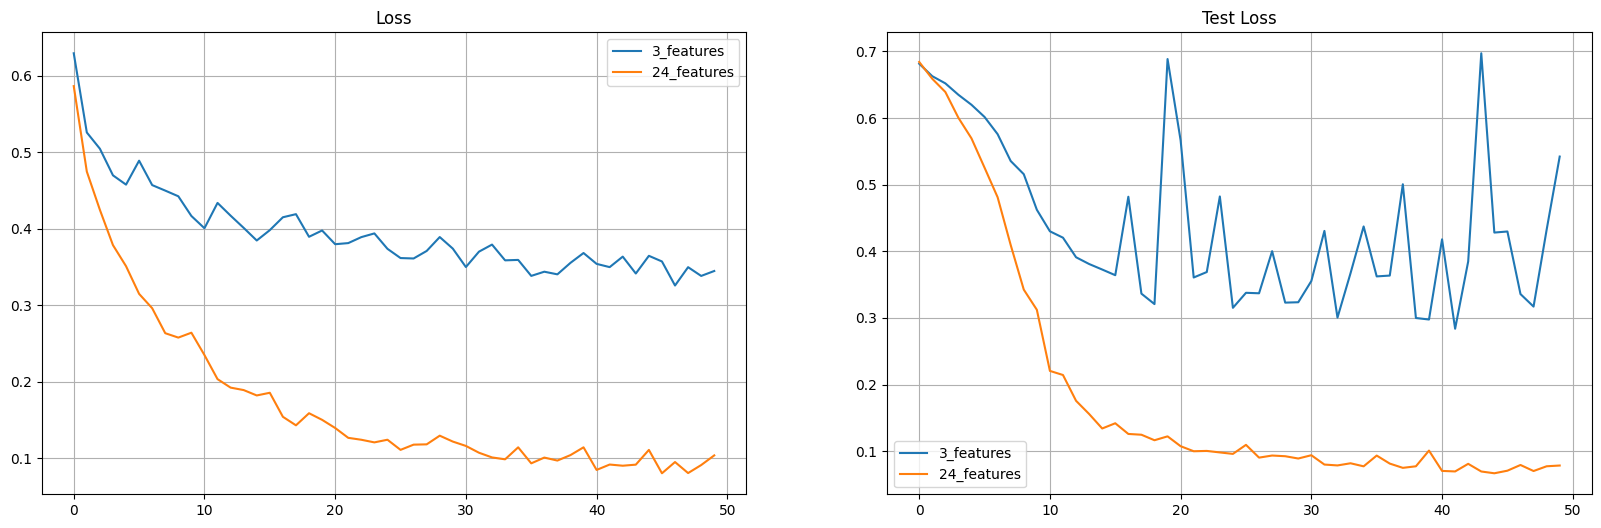

In [63]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(history_bin_simple.history['loss'], label='3_features')
plt.plot(history_bin.history['loss'], label='24_features')
plt.legend(), plt.grid('True')
plt.title('Loss')
plt.subplot(122)
plt.plot(history_bin_simple.history['val_loss'], label='3_features')
plt.plot(history_bin.history['val_loss'], label='24_features')
plt.legend(), plt.grid('True')
plt.title('Test Loss')


Text(0.5, 1.0, 'Test Accuracy')

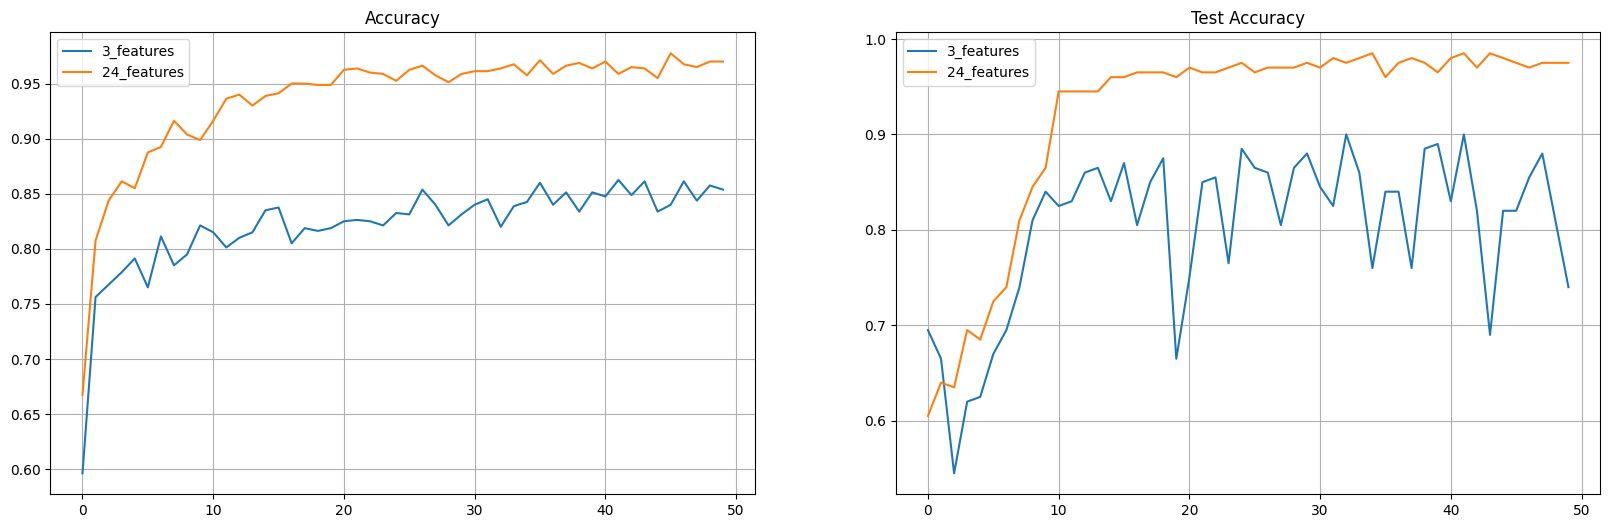

In [65]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(history_bin_simple.history['accuracy'], label='3_features')
plt.plot(history_bin.history['accuracy'], label='24_features')
plt.legend(), plt.grid('True')
plt.title('Accuracy')
plt.subplot(122)
plt.plot(history_bin_simple.history['val_accuracy'], label='3_features')
plt.plot(history_bin.history['val_accuracy'], label='24_features')
plt.legend(), plt.grid('True')
plt.title('Test Accuracy')


# Partie 2 : Multi-class classification 

## Dataset preparation 

In [25]:
datasets_folders = r'C:\Users\Jalil\Desktop\Ecole\M2TSI\tp2\datasets\Movies'

In [26]:
# We compute the size of our datafolders

train_total_size = 0
val_total_size = 0
for folder in os.listdir(datasets_folders):
    if folder.endswith('01'):
        train_total_size  += len(os.listdir(os.path.join(datasets_folders, folder)))
    elif folder.endswith('02'):
        val_total_size += len(os.listdir(os.path.join(datasets_folders, folder)))

In [27]:
# We create empty array to store our images

dataset_mult_01 = np.empty(shape=(train_total_size, 540, 920, 3), dtype=np.float32)
dataset_mult_02 = np.empty(shape=(val_total_size, 540, 920, 3), dtype=np.float32)

In [28]:
# This function is flexible depending the amount of folders there is 
i = 0
for folder in os.listdir(datasets_folders):
    if folder.endswith('01'):
        for file in os.listdir(os.path.join(datasets_folders, folder)):
            dataset_mult_01[i] = cv2.imread(os.path.join(datasets_folders, folder, file)) / 255.0
            i += 1

i = 0
for folder in os.listdir(datasets_folders):
    if folder.endswith('02'):
        for file in os.listdir(os.path.join(datasets_folders, folder)):
            dataset_mult_02[i] = cv2.imread(os.path.join(datasets_folders, folder, file)) / 255.0
            i += 1

In [29]:
features_mult_01 = np.empty(shape=(train_total_size, 24))
features_mult_02 = np.empty(shape=(val_total_size, 24))
features_mult_simple_01 = np.empty(shape=(train_total_size, 3))
features_mult_simple_02 = np.empty(shape=(val_total_size, 3))

In [30]:

for i, (image_1, image_2) in enumerate(zip(dataset_mult_01, dataset_mult_02)):
    features_mult_01[i] = extract_features(image_1)
    features_mult_02[i] = extract_features(image_2)
    
for i, (image_1, image_2) in enumerate(zip(dataset_mult_01, dataset_mult_02)):
    features_mult_simple_01[i] = extract_simple_features(image_1)
    features_mult_simple_02[i] = extract_simple_features(image_2)

In [31]:
target_mult_train = np.zeros(train_total_size)
target_mult_train[500:] = 1
target_mult_train[1000:] = 2
target_mult_train[1500:] = 3

In [32]:
target_mult_val = np.zeros(val_total_size)
target_mult_val[500:] = 1
target_mult_val[1000:] = 2
target_mult_val[1500:] = 3

In [33]:
target_cat_train = to_categorical(target_mult_train)
target_cat_val = to_categorical(target_mult_val)

In [34]:
x_train_mult, x_test_mult, y_train_mult, y_test_mult = train_test_split(features_mult_01, target_cat_train, train_size=0.8, shuffle=True, random_state=13)
x_train_mult_simple, x_test_mult_simple, y_train_mult_simple, y_test_mult_simple = train_test_split(features_mult_simple_01, target_cat_train, train_size=0.8, shuffle=True, random_state=13)

## Model creation for multiclass 

### Simple features

In [35]:
input = Input(shape=(3,))
x = Dense(units=32)(input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(units=16)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
output = Dense(units=4, activation='softmax')(x)

model_mult_class_simple = Model(input, output)

In [36]:
model_mult_class_simple.summary()
optimizer = Adam(learning_rate=0.005)
model_mult_class_simple.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=['accuracy'])

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 916 (3.58 KB)

 Trainable params: 820 (3.20 KB)

 Non-trainable params: 96 (384.00 B)

In [37]:
history_mult_class_simple = model_mult_class_simple.fit(
    x=x_train_mult_simple,
    y=y_train_mult_simple,
    batch_size=16,
    epochs=50,
    validation_data=(x_test_mult_simple, y_test_mult_simple)
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4299 - loss: 1.2846 - val_accuracy: 0.2725 - val_loss: 1.3772
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5111 - loss: 1.1583 - val_accuracy: 0.3850 - val_loss: 1.3402
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5521 - loss: 1.0866 - val_accuracy: 0.4025 - val_loss: 1.3235
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5575 - loss: 1.0530 - val_accuracy: 0.3375 - val_loss: 1.3396
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5634 - loss: 1.0607 - val_accuracy: 0.5375 - val_loss: 1.1420
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5690 - loss: 1.0396 - val_accuracy: 0.5600 - val_loss: 1.0652
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5384 - loss: 1.0641 - val_accuracy: 0.4775 - val_loss: 1.2618
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5643 - loss: 1.0432 - val_accuracy: 0.

In [38]:
evaluation_mult_class_simple = model_mult_class_simple.evaluate(features_mult_simple_02, target_cat_val)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.4594 - loss: 1.6277


### More complex features

In [39]:
input = Input(shape=(24,))
x = Dense(units=32)(input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(units=16)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
output = Dense(units=4, activation='softmax')(x)

model_mult_class = Model(input, output)

In [40]:
model_mult_class.summary()
optimizer = Adam(learning_rate=0.005)
model_mult_class.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=['accuracy'])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,588 (6.20 KB)

 Trainable params: 1,492 (5.83 KB)

 Non-trainable params: 96 (384.00 B)

In [41]:
history_mult_class = model_mult_class.fit(
    x=x_train_mult,
    y=y_train_mult,
    batch_size=16,
    epochs=50,
    validation_data=(x_test_mult, y_test_mult)
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4317 - loss: 1.2794 - val_accuracy: 0.2850 - val_loss: 1.3714
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6214 - loss: 0.9214 - val_accuracy: 0.3750 - val_loss: 1.3153
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6606 - loss: 0.8338 - val_accuracy: 0.5600 - val_loss: 1.1021
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6780 - loss: 0.8029 - val_accuracy: 0.4350 - val_loss: 1.1463
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6657 - loss: 0.7832 - val_accuracy: 0.6650 - val_loss: 0.8360
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6930 - loss: 0.7706 - val_accuracy: 0.5575 - val_loss: 1.0211
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7181 - loss: 0.7164 - val_accuracy: 0.6150 - val_loss: 0.9705
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6721 - loss: 0.7575 - val_accuracy: 0.

In [42]:
evaluation_mult_class = model_mult_class.evaluate(features_mult_02, target_cat_val)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2250 - loss: 2.0696 


### Compare the results

Text(0.5, 1.0, 'Test Loss')

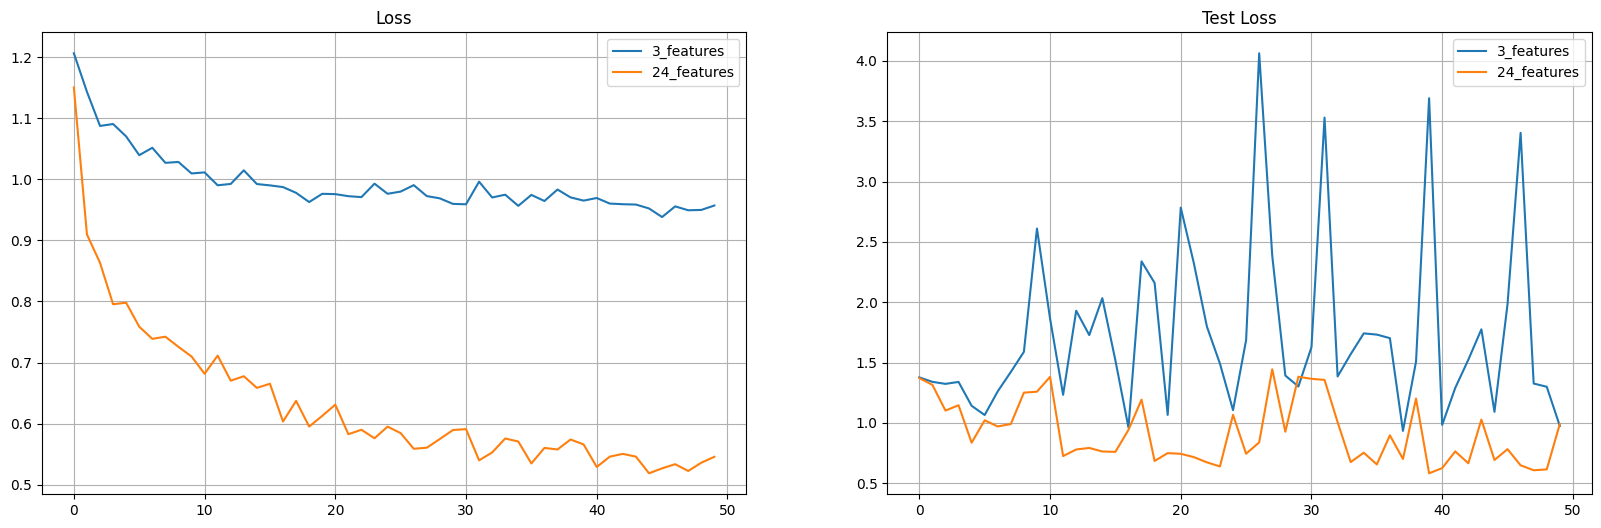

In [66]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(history_mult_class_simple.history['loss'], label='3_features')
plt.plot(history_mult_class.history['loss'], label='24_features')
plt.legend(), plt.grid('True')
plt.title('Loss')
plt.subplot(122)
plt.plot(history_mult_class_simple.history['val_loss'], label='3_features')
plt.plot(history_mult_class.history['val_loss'], label='24_features')
plt.legend(), plt.grid('True')
plt.title('Test Loss')


Text(0.5, 1.0, 'Test Loss')

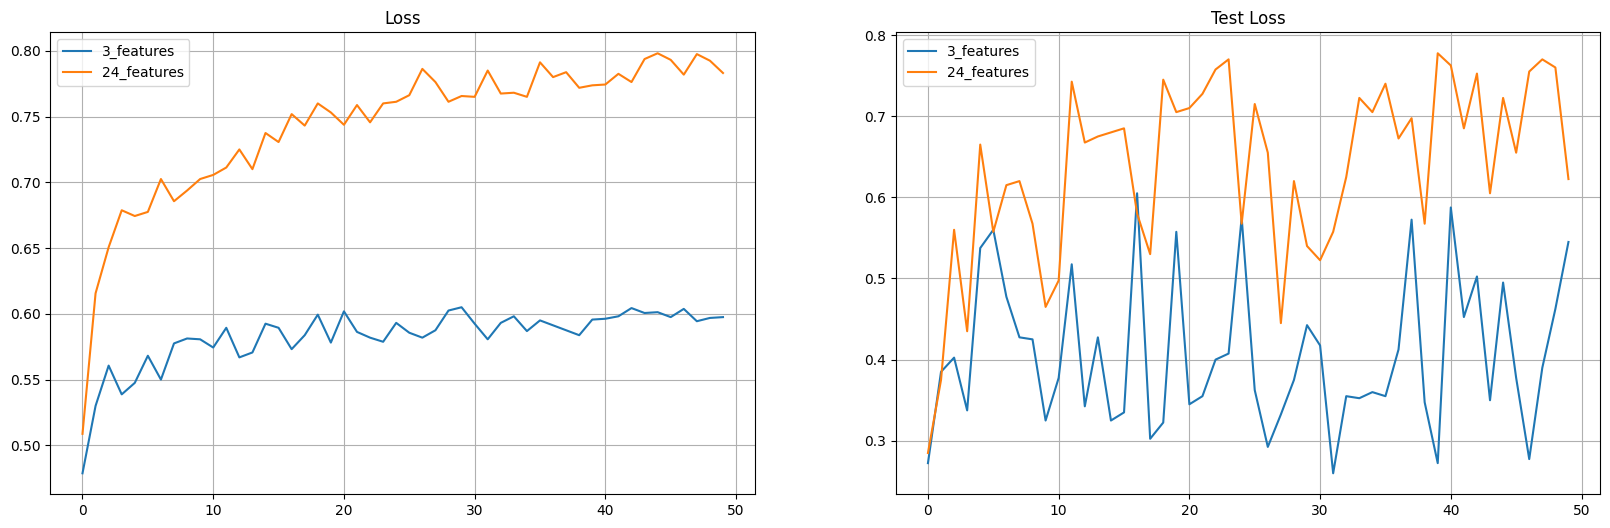

In [67]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(history_mult_class_simple.history['accuracy'], label='3_features')
plt.plot(history_mult_class.history['accuracy'], label='24_features')
plt.legend(), plt.grid('True')
plt.title('Loss')
plt.subplot(122)
plt.plot(history_mult_class_simple.history['val_accuracy'], label='3_features')
plt.plot(history_mult_class.history['val_accuracy'], label='24_features')
plt.legend(), plt.grid('True')
plt.title('Test Loss')

# Saving results in an excel

history_mult_class_simple
history_mult_class
history_bin_simple
history_bin

In [45]:
work_dir = 'c:/Users/Jalil/Desktop/Ecole/M2TSI/tp2/'
excel_path = os.path.join(work_dir, 'excel_sheet_Benhiba_tp2.xlsx')

In [49]:
print(history_bin_simple.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [55]:
# TODO: rework on the creation of the dictionnary 

excel_dict = {
    'loss_bin_simple': history_bin_simple.history['loss'],
    'loss_bin_simple_test': history_bin_simple.history['val_loss'],
    'accuracy_bin_simple': history_bin_simple.history['accuracy'],
    'accuracy_bin_simple_test': history_bin_simple.history['val_accuracy'],
    'loss_bin': history_bin.history['loss'],
    'loss_bin_test': history_bin.history['val_loss'],
    'accuracy_bin': history_bin.history['accuracy'],
    'accuracy_bin_test': history_bin.history['val_accuracy'],
    'loss_mult_simple': history_mult_class_simple.history['loss'],
    'loss_mult_simple_test': history_mult_class_simple.history['val_loss'],
    'accuracy_mult_simple': history_mult_class_simple.history['accuracy'],
    'accuracy_mult_simple_test': history_mult_class_simple.history['val_accuracy'],
    'loss_mult': history_mult_class.history['loss'],
    'loss_mult_test': history_mult_class.history['val_loss'],
    'accuracy_mult': history_mult_class.history['accuracy'],
    'accuracy_mult_test': history_mult_class.history['val_accuracy']
}

In [56]:
df = pd.DataFrame(excel_dict)
df.to_excel(excel_path, index=False)